In [15]:
import math

import numpy as np
from numba import njit
import matplotlib.pyplot as plt
import time
import os
import tracemalloc
import sys


fastmath = False
cache = False

angles = np.array([[0.0, 0.0, 0.0, 0.0, 0.0],
                   [np.pi/2, np.pi/2, 4*np.pi/9, np.pi/9, 4*np.pi/9],
                   [np.pi, 17*np.pi/18, 5*np.pi/9, 5*np.pi/9, 17*np.pi/18],
                   [5*np.pi/9, 17*np.pi/18, np.pi, 17*np.pi/18, 5*np.pi/9],
                   [4*np.pi/9, np.pi/2, np.pi/2, 4*np.pi/9, np.pi/9]])


#-----------------------------------------------------------
# SYSTEM CREATION
#-----------------------------------------------------------
#@njit(fastmath=fastmath, cache=cache)
def polymergenerator(polymerl, headl, unit_distance=4.13):
    # Create polymer: each row is a 3D coordinate (x,y,z)
    polymer = np.empty((polymerl, 3))
    for i in range(polymerl):
        polymer[i, 0] = float(i) * unit_distance
        polymer[i, 1] = 20.0
        polymer[i, 2] = 20.0

    # Create polymer surface as 2 x 14 copies of the polymer, with offsets on a circle (radius = 14.875 nm)
    num_copies = 14
    polymersurfaceP = np.empty((num_copies, polymerl, 3))
    polymersurfaceN = np.empty((num_copies, polymerl, 3))
    for k in range(num_copies):
        angle = 2.0 * np.pi * k / num_copies
        offset0 = 0.0
        offset1 = 14.875 * np.cos(angle) #final radius = 14.875 nm
        offset2 = 14.875 * np.sin(angle)
        for i in range(polymerl):
            polymersurfaceP[k, i, 0] = polymer[i, 0] + offset0
            polymersurfaceP[k, i, 1] = polymer[i, 1] + offset1
            polymersurfaceP[k, i, 2] = polymer[i, 2] + offset2
            polymersurfaceN[k, i, 0] = polymersurfaceP[k, i, 0] + 0.1734 * unit_distance
            polymersurfaceN[k, i, 1] = polymersurfaceP[k, i, 1]
            polymersurfaceN[k, i, 2] = polymersurfaceP[k, i, 2]
    polymersurfaceN = polymersurfaceN.reshape((140,3))
    polymersurfaceP = polymersurfaceP.reshape((140,3))
    # For the protein heads, create one COM per head.
    # Head 0 is at [16.8, 38.0, 20.1]; each subsequent head is shifted 4 nm in x.
    COM0 = np.array([16.8, 38.0, 20.1])
    COMs = np.empty((headl, 3))
    for h in range(headl):
        COMs[h, 0] = COM0[0] + 4.13 * h
        COMs[h, 1] = COM0[1]
        COMs[h, 2] = COM0[2]

    # Create a head surface from a set of offsets (same for every head)
    offsets = np.array([[0.5, 0.0, 0.0],
                        [0.0, 0.5, 0.0],
                        [-0.5, 0.0, 0.0],
                        [-0.0867, -0.492, 0.0],
                        [0.0867, -0.492, 0.0]])
    n_surface = offsets.shape[0]  # here, 5 points per head surface
    headsurfaces = np.empty((headl, n_surface, 3))
    for h in range(headl):
        for i in range(n_surface):
            headsurfaces[h, i, 0] = COMs[h, 0] + offsets[i, 0] * unit_distance
            headsurfaces[h, i, 1] = COMs[h, 1] + offsets[i, 1] * unit_distance
            headsurfaces[h, i, 2] = COMs[h, 2] + offsets[i, 2] * unit_distance

    return polymer, COMs, headsurfaces, polymersurfaceP, polymersurfaceN


#-----------------------------------------------------------
# FORCES
#-----------------------------------------------------------

@njit(fastmath=fastmath, cache=cache)
def morse(a, b, D, maxf):
    sigma = np.log(2)/maxf # maxf is distance at which froce is the greatest
    f_total = np.zeros(3)
    for i in range(a.shape[0]):
        dif0 = a[i, 0] - b[0]
        dif1 = a[i, 1] - b[1]
        dif2 = a[i, 2] - b[2]
        dist = np.sqrt(dif0 * dif0 + dif1 * dif1 + dif2 * dif2)
        if dist == 0:
            continue
        exp_val = np.exp(-sigma * dist)
        f_val = 2 * sigma * D * exp_val * (1.0 - exp_val)   # optimised version of: 2*sigma*D*(np.e**(-sigma*dist))*(1-np.e**(-sigma*dist)), max force = 1/2 * sigma * D, at x = 1/a * ln(2)
        inv_dist = 1.0 / dist
        f_total[0] += f_val * dif0 * inv_dist
        f_total[1] += f_val * dif1 * inv_dist
        f_total[2] += f_val * dif2 * inv_dist
    return f_total


@njit(fastmath=fastmath, cache=cache)
def repulsive(a, b, epsilon=0.1, sigma=1):
    f_total = np.zeros(3)
    for i in range(a.shape[0]):
        dif1 = a[i, 1] - b[1]
        dif2 = a[i, 2] - b[2]
        dist = np.sqrt(dif1 * dif1 + dif2 * dif2)
        if dist>sigma or dist==0:
            continue
        f_val  = -2 * epsilon * (sigma - dist)
        inv_dist = 1.0 / dist
        f_total[1] += f_val * dif1 * inv_dist
        f_total[2] += f_val * dif2 * inv_dist
    return f_total


@njit(fastmath=fastmath, cache=cache)
def repulsive_particle(a, b, epsilon=0.1, sigma=1):
    f_total = np.zeros(3)
    for i in range(a.shape[0]):
        dif0 = a[i, 0] - b[0]
        dif1 = a[i, 1] - b[1]
        dif2 = a[i, 2] - b[2]
        dist = np.sqrt(dif0*dif0 + dif1 * dif1 + dif2 * dif2)
        if dist>sigma or dist==0:
            continue
        f_val  = -2 * epsilon * (sigma - dist)
        inv_dist = 1.0 / dist
        f_total[0] += f_val * dif0 * inv_dist
        f_total[1] += f_val * dif1 * inv_dist
        f_total[2] += f_val * dif2 * inv_dist
    return f_total


@njit(fastmath=fastmath, cache=cache)
def harmonic_angle(surface, COM, n, angles, K=0.01):
    N = surface.shape[0]
    force = np.empty((N, 3))
    for i in range(N):
        j = (i + n) % N
        ab0 = surface[i, 0] - COM[0]
        ab1 = surface[i, 1] - COM[1]
        ab2 = surface[i, 2] - COM[2]
        bc0 = surface[j, 0] - COM[0]
        bc1 = surface[j, 1] - COM[1]
        bc2 = surface[j, 2] - COM[2]
        ab_norm = np.sqrt(ab0 * ab0 + ab1 * ab1 + ab2 * ab2)
        bc_norm = np.sqrt(bc0 * bc0 + bc1 * bc1 + bc2 * bc2)
        if ab_norm == 0.0 or bc_norm == 0.0:
            force[i, 0] = 0.0
            force[i, 1] = 0.0
            force[i, 2] = 0.0
            continue
        cos_angle = (ab0 * bc0 + ab1 * bc1 + ab2 * bc2) / (ab_norm * bc_norm)
        if cos_angle > 1.0:
            cos_angle = 1.0
        elif cos_angle < -1.0:
            cos_angle = -1.0
        angle_diff = angles[n,i] - np.arccos(cos_angle)
        cross_inner0 = bc1 * ab2 - bc2 * ab1
        cross_inner1 = bc2 * ab0 - bc0 * ab2
        cross_inner2 = bc0 * ab1 - bc1 * ab0
        vec0 = ab1 * cross_inner2 - ab2 * cross_inner1
        vec1 = ab2 * cross_inner0 - ab0 * cross_inner2
        vec2 = ab0 * cross_inner1 - ab1 * cross_inner0
        vec_norm = np.sqrt(vec0 * vec0 + vec1 * vec1 + vec2 * vec2)
        if vec_norm != 0.0:
            factor = -2 * K * angle_diff / vec_norm
            force[i, 0] = factor * vec0
            force[i, 1] = factor * vec1
            force[i, 2] = factor * vec2
        else:
            force[i, 0] = 0.0
            force[i, 1] = 0.0
            force[i, 2] = 0.0
    return force


@njit(fastmath=fastmath, cache=cache)
def harmonic_surface(surface, COM, epsilon=0.01, sigma=2.065):
    N = surface.shape[0]
    force = np.empty((N, 3))
    for i in range(N):
        dx = surface[i, 0] - COM[0]
        dy = surface[i, 1] - COM[1]
        dz = surface[i, 2] - COM[2]
        norm_val = np.sqrt(dx * dx + dy * dy + dz * dz)
        if norm_val > 0:
            factor = 2 * epsilon * (sigma - norm_val) / norm_val
            force[i, 0] = factor * dx
            force[i, 1] = factor * dy
            force[i, 2] = factor * dz
        else:
            force[i, 0] = 0.0
            force[i, 1] = 0.0
            force[i, 2] = 0.0
    return force


@njit(fastmath=fastmath, cache=cache)
def neighbour(COM):
    dy = COM[1] - 20
    dz = COM[2] - 20
    theta = math.atan2(dz, dy)
    if theta < 0.0:
        theta += 2.0 * math.pi
        # scale to column index
    inv_bin = 14 / (2.0 * math.pi)
    ida = int(theta * inv_bin)
    if ida >= 14:
        ida = 0
    idx = int(COM[0]/4.13)
    return ida, idx


@njit(fastmath=fastmath, cache=cache)
def get_surface_patch(polysurface, idtheta, idx, wt, wx):
    """
    Return a (2*wt+1)*(2*wx+1) patch of MT surface points around (idtheta, idx),
    spanning wt columns in theta and wx steps along x, with wrap-around.
    """
    num_t = 14
    num_x = 10
    size = (2 * wt + 1) * (2 * wx + 1)
    patch = np.empty((size, 3))
    k = 0
    for dt in range(-wt, wt + 1):
        t = (idtheta + dt) % num_t
        for dx in range(-wx, wx + 1):
            x = (idx + dx) % num_x
            patch[k, :] = polysurface[t, x]
            k += 1
    return patch

#-----------------------------------------------------------
# TIME INTEGRATION FOR MULTIPLE HEADS
#-----------------------------------------------------------
@njit(fastmath=fastmath, cache=cache)
def notverlet_multiple(COMs, surfaces, dt, random_val, mu, polymer, polymersurfaceP, polymersurfaceN, epsi):
    n_heads = COMs.shape[0]
    n_surface = surfaces.shape[1]
    new_COMs = np.empty_like(COMs)
    new_surfaces = np.empty_like(surfaces)
    # For COM forces (from polymer + later head-head interactions)
    COM_forces = np.empty_like(COMs)
    # For surface forces per head
    surface_forces = np.empty_like(surfaces)
    # First, per-head contributions (without head-head interactions)
    for h in range(n_heads):
        force1 = harmonic_angle(surfaces[h], COMs[h], 1, angles)
        force2 = harmonic_angle(surfaces[h], COMs[h], 2, angles)
        force3 = harmonic_angle(surfaces[h], COMs[h], -2, angles)
        force4 = harmonic_angle(surfaces[h], COMs[h], -1, angles)
        angle_forces = force1 + force2 + force3 + force4
        harmonic_bond = harmonic_surface(surfaces[h], COMs[h])
        lj_force_surf = np.zeros_like(surfaces[h])
        #idtheta, idx = neighbour(COMs[h])
        #surfaceneighbourP = get_surface_patch(polymersurfaceP, idtheta, idx, 2, 2)
        #surfaceneighbourN = get_surface_patch(polymersurfaceN, idtheta, idx, 2, 2)
        #lj_force_surf[3] = morse(surfaceneighbourP, surfaces[h, 3], epsi, 1)
        #lj_force_surf[4] = morse(surfaceneighbourN, surfaces[h, 4], epsi, 1)
        lj_force_surf[3] = morse(polymersurfaceP, surfaces[h, 3], epsi, 1)
        lj_force_surf[4] = morse(polymersurfaceN, surfaces[h, 4], epsi, 1)
        for i in range(n_surface):
            surface_forces[h, i, 0] = angle_forces[i, 0] + harmonic_bond[i, 0] + lj_force_surf[i, 0]
            surface_forces[h, i, 1] = angle_forces[i, 1] + harmonic_bond[i, 1] + lj_force_surf[i, 1]
            surface_forces[h, i, 2] = angle_forces[i, 2] + harmonic_bond[i, 2] + lj_force_surf[i, 2]

        # COM force from polymer repulsion
        COM_forces[h] = repulsive(polymer, COMs[h], 0.00005, 16.875)
        harmonic_sum = np.zeros(3)
        for i in range(n_surface):
            harmonic_sum[0] += harmonic_bond[i, 0]
            harmonic_sum[1] += harmonic_bond[i, 1]
            harmonic_sum[2] += harmonic_bond[i, 2]
        COM_forces[h, 0] -= harmonic_sum[0]
        COM_forces[h, 1] -= harmonic_sum[1]
        COM_forces[h, 2] -= harmonic_sum[2]

    # Head-head interactions (compute each pair only once)
    for h in range(n_heads):
        for m in range(h + 1, n_heads):
            a = np.empty((1, 3))
            a[0, 0] = surfaces[m, 2, 0]
            a[0, 1] = surfaces[m, 2, 1]
            a[0, 2] = surfaces[m, 2, 2]
            f = morse(surfaces[m,2].reshape((1,3)), surfaces[h, 0], 0.000001, 1.0)
            surface_forces[h, 0, 0] += f[0]
            surface_forces[h, 0, 1] += f[1]
            surface_forces[h, 0, 2] += f[2]
            surface_forces[m, 2, 0] -= f[0]
            surface_forces[m, 2, 1] -= f[1]
            surface_forces[m, 2, 2] -= f[2]
            a_com = np.empty((1, 3))
            a_com[0, 0] = COMs[m, 0]
            a_com[0, 1] = COMs[m, 1]
            a_com[0, 2] = COMs[m, 2]
            f_com = repulsive_particle(COMs[m].reshape((1,3)), COMs[h], 0.00001, 4.13)
            COM_forces[h, 0] += f_com[0]
            COM_forces[h, 1] += f_com[1]
            COM_forces[h, 2] += f_com[2]
            COM_forces[m, 0] -= f_com[0]
            COM_forces[m, 1] -= f_com[1]
            COM_forces[m, 2] -= f_com[2]
    # Update surfaces and COMs
    for h in range(n_heads):
        for i in range(n_surface):
            for j in range(3):
                new_surfaces[h, i, j] = surfaces[h, i, j] + dt * mu * surface_forces[h, i, j]
        for j in range(3):
            new_COMs[h, j] = COMs[h, j] + dt * (mu * COM_forces[h, j] + random_val[h,j])

        # Box-boundary corrections per head
        if new_COMs[h, 0] < 4.13:
            new_COMs[h, 0] += 12.39
            for i in range(n_surface):
                new_surfaces[h, i, 0] += 12.39
        elif new_COMs[h, 0] > 33.04:
            new_COMs[h, 0] -= 12.39
            for i in range(n_surface):
                new_surfaces[h, i, 0] -= 12.39
        if new_COMs[h, 1] > 100.0:
            new_COMs[h, 1] -= 50.0
            for i in range(n_surface):
                new_surfaces[h, i, 1] -= 50.0
        elif new_COMs[h, 1] < -60.0:
            new_COMs[h, 1] += 50.0
            for i in range(n_surface):
                new_surfaces[h, i, 1] += 50.0
        if new_COMs[h, 2] > 100.0:
            new_COMs[h, 2] -= 50.0
            for i in range(n_surface):
                new_surfaces[h, i, 2] -= 50.0
        elif new_COMs[h, 2] < -60.0:
            new_COMs[h, 2] += 50.0
            for i in range(n_surface):
                new_surfaces[h, i, 2] += 50.0
    return new_COMs, new_surfaces


#-----------------------------------------------------------
# SIMULATION FOR MULTIPLE HEADS IN SEGMENTS
#-----------------------------------------------------------
@njit(fastmath=fastmath, cache=cache)
def simulate_segment(COMs, surfaces, polymer, polymersurfaceP, polymersurfaceN, steps, dt, mu, rand_COM_array, hist_every, epsi):
    histsize = steps // hist_every
    headhist = np.empty((histsize, COMs.shape[0], 3))
    surfacehist = np.empty((histsize, surfaces.shape[0], surfaces.shape[1], 3))
    headhist[0] = COMs
    surfacehist[0] = surfaces
    for i in range(steps):
        COMs, surfaces = notverlet_multiple(COMs, surfaces, dt, rand_COM_array[i], mu, polymer, polymersurfaceP,
                                            polymersurfaceN, epsi)
        if (i % hist_every) == 0:
            headhist[i // hist_every] = COMs
            surfacehist[i // hist_every] = surfaces
        #if i % print_every == 0:
        #    print("Step", i, "/", steps, "COM:", COM[0], COM[1], COM[2])
    return headhist, surfacehist, COMs, surfaces

#----------------------------------------------------------------------------
# Fully njitted segmented simulation driver.
#----------------------------------------------------------------------------
@njit(fastmath=fastmath, cache=cache)
def segmented_simulation(COM, surface, polymer, polymersurfaceP, polymersurfaceN, total_steps, dt, mu, batch_size, random_val, hist_every, epsi, headN):
    num_segments = total_steps // batch_size
    batch_histsize = batch_size // hist_every
    total_histsize = num_segments * batch_histsize
    headhist_full = np.empty((total_histsize,headN, 3))
    surfacehist_full = np.empty((total_histsize, headN, surface.shape[1], 3))
    seg_idx = 0
    current_COM = COM.copy()
    current_surface = surface.copy()
    for seg in range(num_segments):
        rand_COM_array = np.random.uniform(-random_val, random_val, size=(batch_size, headN, 3))
        headhist_batch, surfacehist_batch, final_COM, final_surface = simulate_segment(current_COM, current_surface, polymer, polymersurfaceP, polymersurfaceN, batch_size, dt, mu, rand_COM_array, hist_every, epsi)
        for k in range(batch_histsize):
            headhist_full[seg_idx + k] = headhist_batch[k]
            surfacehist_full[seg_idx + k] = surfacehist_batch[k]
        seg_idx += batch_histsize
        current_COM = final_COM.copy()
        current_surface = final_surface.copy()
    return headhist_full, surfacehist_full


def plotter(headhistv,id, save=False):
    plt.style.use('dark_background')
    render_everyN = 1
    orthogonal_distance = np.linalg.norm(headhistv[::render_everyN, 1:3]-[20,20], axis=1)
    time_arr = np.arange(steps/(render_everyN*hist_every))*render_everyN*hist_every*dt/(steps *10^9)
    fig, ax = plt.subplots(ncols=2, nrows=3, figsize=(10,10), gridspec_kw={'height_ratios': [3, 1,2]})
    pos = ax[0,0].scatter(headhistv[::render_everyN, 2]-20, headhistv[::render_everyN, 1]-20, cmap="gist_rainbow", c=time_arr, s=0.1)
    ax[0,0].set_xlim(-25, 25)
    ax[0,0].set_ylim(-25, 25)
    ax[0,0].set_title("MT crosssection (y and z coordinates) over time", fontsize=8)
    ax[0,0].set_xlabel("z coordinate (nm)", fontsize=8)
    ax[0,0].set_ylabel("y coordinate (nm)", fontsize=8)
    ax[0,0].set_aspect("equal", adjustable="box")
    perp = ax[0,1].scatter(headhistv[::render_everyN, 0], orthogonal_distance[::], cmap="gist_rainbow", c=time_arr, s=0.1)
    ax[0,1].set_xlim(0, 40)
    ax[0,1].set_ylim(0, 40)
    ax[0,1].set_title("orthogonal distance from the central axis of the MT and x-coordinate (along MT) over time", fontsize=8)
    ax[0,1].set_xlabel("x coordinate (nm)", fontsize=8)
    ax[0,1].set_ylabel("orthogonal distance (nm)", fontsize=8)
    ax[0,1].set_aspect("equal", adjustable="box")
    ax[2,1].hist(orthogonal_distance, bins=100, range=(15.0,20))
    ax[2,0].hist(orthogonal_distance[1:]-orthogonal_distance[:-1], bins=90)
    gs = ax[1, 0].get_gridspec()
    fig.colorbar(pos, ax=ax[0,:], label='time (µs)', orientation='horizontal', shrink=0.95)
    # remove the underlying Axes
    for ax in ax[1,:]:
        ax.remove()
    axbig = fig.add_subplot(gs[1, :])
    figigi = axbig.plot(time_arr[::], orthogonal_distance[::], linewidth=1)
    axbig.set_ylim(15,50)
    axbig.set_title("orthogonal distance from the center over time", fontsize=8)
    axbig.set_xlabel('time (µs)')
    axbig.set_ylabel('orthogonal distance (nm)')
    plt.show()
    print("shown")
    if save:
        fig.savefig(f'engine{id}.png')
    print(f"orthogonal_diff_mean:{(orthogonal_distance[1:]-orthogonal_distance[:-1]).mean()}")


if len(sys.argv) == 1:
    job_id = 0
else:
    job_id = sys.argv[1]

#job_var = np.array()

#-----------------------------------------------------------
# RUN THE SIMULATION (SINGLE CORE)
#-----------------------------------------------------------
polymerLength = 10  # ten repeats
headN = 4 # one head
steps = 100_000_000
batch_size = 1_000_000
dt = 10  # fs
#random_val = 0.01 # nm/sqrt(fs)
mu = 0.01 #fs mol/g, gives the viscosity of the medium ~ 5.34 mPa*s
print_every = 10_000_000
hist_every = 10_000
unit_distanceX = 4.13 #nm
temp = 310 #K
random_val = np.sqrt(2.0*8.314*(10.0**-3) * mu * temp)/1000.0
epsi = .000001

directory =  os.getcwd() #"/data/home/bt23708/Ndc80sim/Ndc80simulator/hpcdump/"

# RUN THE SIM

polymer, COMs, surfaces, polymersurfaceP, polymersurfaceN = polymergenerator(polymerLength, headN)
start = time.perf_counter()
headhist, surfacehist = segmented_simulation(COMs, surfaces, polymer, polymersurfaceP, polymersurfaceN,steps, dt, mu, batch_size, random_val, hist_every, epsi, headN)

np.save(f"headhist_{job_id}" , headhist)
print("Simulation complete. Final COM:", headhist[-1], flush=True)
end = time.perf_counter()
print("Elapsed (after compilation) = {}s".format((end - start)), flush=True)

with open("trajectoryn.xyz", "w") as f:
    for t, positionsX in enumerate(np.concatenate(((np.reshape(headhist[::],(int(steps/hist_every),4,1,3))), surfacehist[::]),axis=2)):
        #print(positionsX)
        i = 0
        f.write(f"24 \n \n")
        for positions in positionsX:
            f.write(f"C{1+i} {positions[0,0]:8.4f}{positions[0,1]:8.4f}{positions[0,2]:8.4f} \n")
            f.write(f"C{2+i} {positions[1,0]:8.4f}{positions[1,1]:8.4f}{positions[1,2]:8.4f} \n")
            f.write(f"C{3+i} {positions[2,0]:8.4f}{positions[2,1]:8.4f}{positions[2,2]:8.4f} \n")
            f.write(f"C{4+i} {positions[3,0]:8.4f}{positions[3,1]:8.4f}{positions[3,2]:8.4f} \n")
            f.write(f"C{5+i} {positions[4,0]:8.4f}{positions[4,1]:8.4f}{positions[4,2]:8.4f} \n")
            f.write(f"C{6+i} {positions[5,0]:8.4f}{positions[5,1]:8.4f}{positions[5,2]:8.4f} \n")
            i += 6

Simulation complete. Final COM: [[18.64475958 36.8471232  21.36712496]
 [19.33263881 38.75756536 17.89892059]
 [24.40162836 37.41957311 22.12571053]
 [28.12858367 37.50864713 21.30006374]]
Elapsed (after compilation) = 101.75470866600517s


In [ ]:
 # LEGACY PLOTTING TOOL
render_everyN = 100
orthogonal_distance = np.linalg.norm(headhist[::render_everyN, 1:3]-[20,20], axis=1)
time_arr = np.arange(steps/(render_everyN*hist_every))

#fig, ax = plt.subplots(2, gridspec_kw={'height_ratios': [4, 4]}, figsize=(10, 10))
#fig, ax = plt.subplots(2,gridspec_kw={'height_ratios': [4, 4], "width_ratios": [1]}, figsize=(10,10))
fig, ax = plt.subplots(2, figsize=(20,10), dpi=100)
pos = ax[0].scatter(headhist[::render_everyN, 0], headhist[::render_everyN, 1], cmap="gist_rainbow", c=time_arr, s=1)
#ax[0].set_xlim(4.6, 6.4)
#ax[0].set_ylim(-2.4, 2.4)
#ax[0].set_aspect("equal", adjustable="box")
perp = ax[1].scatter(headhist[::render_everyN, 0], orthogonal_distance[::], cmap="gist_rainbow", c=time_arr, s=0.1)
#ax[1].set_xlim(-0.6, 7.4)
#ax[1].set_ylim(0.5, 4.5)
#ax[1].set_aspect("equal", adjustable="box")
fig.colorbar(pos, ax=ax, label='timestep')
plt.show()

In [ ]:
fig, ax = plt.subplots(dpi=100)
figigi = ax.plot(time_arr[::], orthogonal_distance[::], linewidth=1)

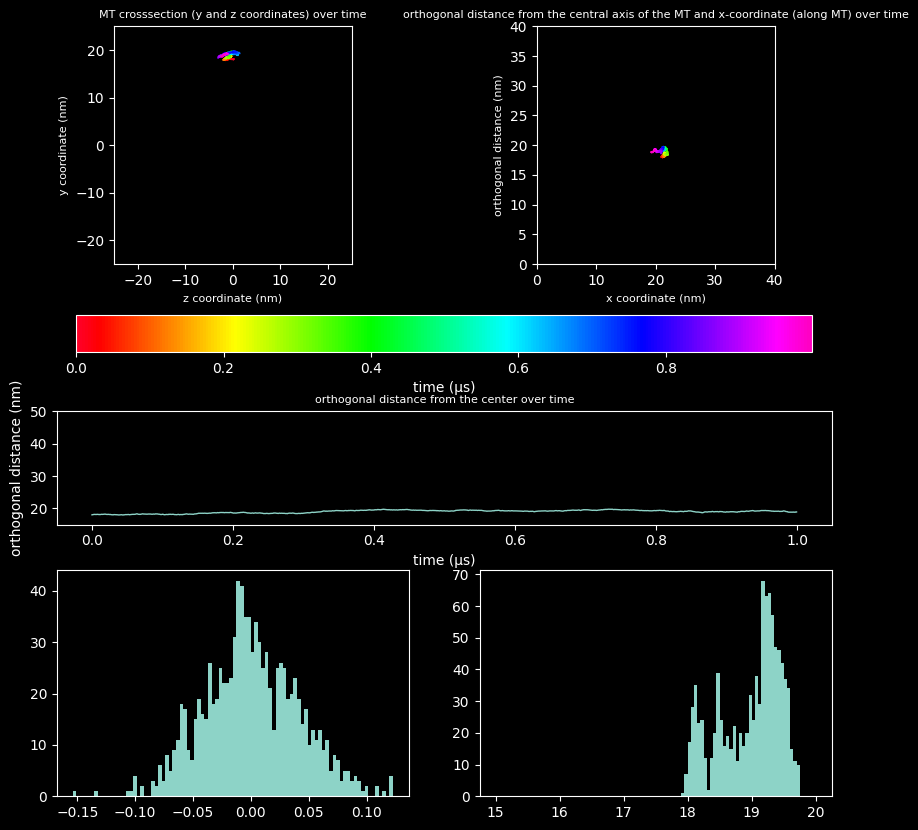

shown
orthogonal_diff_mean:0.0008751247391091918


In [18]:
plotter(headhist[:,1,:], 0)

In [ ]:
with (open("trajectoryn.xyz", "w") as f):
    for t, positions in enumerate(np.concatenate(((np.reshape(headhist[::],(int(steps/hist_every),1,3))), surfacehist[::]),axis=1)):
        #print(positionsX)
        f.write(f"6 \n \n")
        f.write(f"C1 {positions[0,0]:8.4f}{positions[0,1]:8.4f}{positions[0,2]:8.4f} \n")
        f.write(f"C2 {positions[1,0]:8.4f}{positions[1,1]:8.4f}{positions[1,2]:8.4f} \n")
        f.write(f"C3 {positions[2,0]:8.4f}{positions[2,1]:8.4f}{positions[2,2]:8.4f} \n")
        f.write(f"C4 {positions[3,0]:8.4f}{positions[3,1]:8.4f}{positions[3,2]:8.4f} \n")
        f.write(f"C5 {positions[4,0]:8.4f}{positions[4,1]:8.4f}{positions[4,2]:8.4f} \n")
        f.write(f"C6 {positions[5,0]:8.4f}{positions[5,1]:8.4f}{positions[5,2]:8.4f} \n")


In [11]:
with open("trajectoryn.xyz", "w") as f:
    for t, positionsX in enumerate(np.concatenate(((np.reshape(headhist[::],(int(steps/hist_every),4,1,3))), surfacehist[::]),axis=2)):
        #print(positionsX)
        i = 0
        f.write(f"24 \n \n")
        for positions in positionsX:
            f.write(f"C{1+i} {positions[0,0]:8.4f}{positions[0,1]:8.4f}{positions[0,2]:8.4f} \n")
            f.write(f"C{2+i} {positions[1,0]:8.4f}{positions[1,1]:8.4f}{positions[1,2]:8.4f} \n")
            f.write(f"C{3+i} {positions[2,0]:8.4f}{positions[2,1]:8.4f}{positions[2,2]:8.4f} \n")
            f.write(f"C{4+i} {positions[3,0]:8.4f}{positions[3,1]:8.4f}{positions[3,2]:8.4f} \n")
            f.write(f"C{5+i} {positions[4,0]:8.4f}{positions[4,1]:8.4f}{positions[4,2]:8.4f} \n")
            f.write(f"C{6+i} {positions[5,0]:8.4f}{positions[5,1]:8.4f}{positions[5,2]:8.4f} \n")
            i += 6

In [ ]:
print(headhist.shape,surfacehist.shape)

In [ ]:
with open("polymerrn.xyz", "w") as f:
    f.write(f"2800 \n \n")
    for i in range(polymerLength*14):
        f.write(f"C{2*i+7} {polymersurfaceP[i,0]:8.4f}{polymersurfaceP[i,1]:8.4f}{polymersurfaceP[i,2]:8.4f} \n")
        f.write(f"C{2*i+8} {polymersurfaceN[i,0]:8.4f}{polymersurfaceN[i,1]:8.4f}{polymersurfaceN[i,2]:8.4f} \n")
    #for i in range(polymerLength):
     #   f.write(f"ATOM  {i+2:5d}  C   UNK     1    {i:8.4f}{0:8.4f}{0:8.4f}  1.00  0.00           C\n")

In [ ]:
# MULTICORE
import ipyparallel as ipp


polymerLength = 10
headN = 1
steps = 1_000_000_000
batch_size = 1_000_000
dt = 10            # fs
mu = 0.01        # fs mol/g, 0.01 gives the viscosity of the medium ~ 5.34 mPa*s
print_every = 100000000
hist_every = 1000
unit_distanceX = 4.13 # nm
temp = 311.4            # K
random_val = np.sqrt(2.0*8.314*(10.0**-3) *mu * temp)/1000.0   #the term under the sqrt is in pm^2/fs -> divided by 1000 later to bring units to nm/sqrt(fs)
n_proc = 8
rc = ipp.Cluster(n=n_proc).start_and_connect_sync()
rc.ids
dview = rc[:]  # get a DirectView of all engines

# Push the necessary simulation functions and parameters to each engine.
# Adjust the names as needed to match your notebook's variables.

# variable epsilon for surface interaction lj
epsilons = [0.000032]
#K = [1, 0.1, 0.1, 0.1 , 0.0001, 0.0001, 0.0001, 0.00001]
#for n in range(n_proc):
    #epsilons.append((0.0006+0.000*n)) # epsilons.append((0.0009+0.000010*n)) works well, in GJ/mol
    #K.append((0.000+0.000*n))
dview.scatter('epsilons', epsilons)

dview.push({
    'segmented_simulation': segmented_simulation,
    'polymergenerator': polymergenerator,
    'simulate':simulate,
    'polymerLength': polymerLength,
    'headN': headN,
    'steps': steps,
    'dt': dt,
    'random_val': random_val,
    'mu': mu,
    'print_every': print_every,
    'hist_every': hist_every,
    'epsilons': epsilons,
    'batch_size': batch_size
})



with dview.sync_imports():
    import time

# define run
def run_simulation_instance():
    print(epsilons)
    start = time.perf_counter()
    polymer, COM, surface, polymersurfaceP, polymersurfaceN = polymergenerator(polymerLength, headN)
    headhist, surfacehist = segmented_simulation(COM, surface, polymer, polymersurfaceP, polymersurfaceN,
                                               steps, dt, mu, batch_size, random_val, hist_every, epsilons[0])
    end = time.perf_counter()
    elapsed = end - start
    return {'headhist': headhist, 'surfacehist': surfacehist, 'elapsed': elapsed}

# run
dview.execute("import numpy as np")
async_results = dview.apply_async(run_simulation_instance)

# get results and shutdown engines
results = async_results.get()
rc.shutdown(hub=True)

# plot for each
for idx, res in enumerate(results):
    print(f"Engine {idx}:")
    plotter(res['headhist'], idx, True)
    print("Elapsed (after compilation) = {}s".format((res['elapsed'])))


In [ ]:
      # output trajectory to .xyz
for idx, res in enumerate(results):
    with open(f"trajectoryn{idx}.xyz", "w") as f:
        for t, positions in enumerate(np.concatenate(((np.reshape(res['headhist'[::]],(int(steps/hist_every),1,3))), res['surfacehist'][::]),axis=1)):
            if t % 10 == 0:
                f.write(f"6 \n \n")
                f.write(f"C1 {positions[0,0]:8.4f}{positions[0,1]:8.4f}{positions[0,2]:8.4f} \n")
                f.write(f"C2 {positions[1,0]:8.4f}{positions[1,1]:8.4f}{positions[1,2]:8.4f} \n")
                f.write(f"C3 {positions[2,0]:8.4f}{positions[2,1]:8.4f}{positions[2,2]:8.4f} \n")
                f.write(f"C4 {positions[3,0]:8.4f}{positions[3,1]:8.4f}{positions[3,2]:8.4f} \n")
                f.write(f"C5 {positions[4,0]:8.4f}{positions[4,1]:8.4f}{positions[4,2]:8.4f} \n")
                f.write(f"C6 {positions[5,0]:8.4f}{positions[5,1]:8.4f}{positions[5,2]:8.4f} \n")

 # Utilities bellow

In [ ]:
for idx, res in enumerate(results):
    print(f"Engine {idx}:")
    #plotter(res['headhist'], idx, True)
    np.save(f"headhist{idx}.npy", res['headhist'])
    np.save(f"surfacehist{idx}.npy", res['surfacehist'])
    print("Elapsed (after compilation) = {}s".format((res['elapsed'])))

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
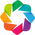

ValueError: operands could not be broadcast together with shapes (1000,3) (1000,) 

In [8]:
# ALTERNATIVE PLOTTER
import holoviews as hv
import datashader as ds
import holoviews.operation.datashader as hd
import pandas as pd
import numpy as np

hv.extension('bokeh')

# Use the same subsampling as before
render_everyN = 1
# Create a time array for the rendered points
time_arr = np.arange(steps/(render_everyN*hist_every))

# Prepare DataFrames for the two plots.
# Plot 1: Scatter of COM x vs. COM y
df1 = pd.DataFrame({
    'x': headhist[::render_everyN, 0],
    'y': headhist[::render_everyN, 1],
    'time': headhist[::render_everyN, 0] * 0.0 + time_arr  # associate time (or use headhist if desired)
})

# Plot 2: Scatter of COM x vs. orthogonal distance
orthogonal_distance = np.linalg.norm(headhist[::render_everyN, 1:3], axis=1)
df2 = pd.DataFrame({
    'x': headhist[::render_everyN, 0],
    'y': orthogonal_distance,
    'time': time_arr
})

# Create Holoviews Points objects.
points1 = hv.Points(df1, kdims=['x', 'y'], vdims=['time'])
points2 = hv.Points(df2, kdims=['x', 'y'], vdims=['time'])

# Apply Datashader to each plot for interactive aggregation.
shaded1 = hd.datashade(points1, cmap="gist_rainbow", aggregator=ds.mean('time'))
shaded2 = hd.datashade(points2, cmap="gist_rainbow", aggregator=ds.mean('time'))

# Set options (titles, colorbars, dimensions, etc.)
shaded1 = shaded1.opts(title="COM Trajectory (x vs. y)",
                       frame_width=600, frame_height=400, bgcolor='black')
shaded2 = shaded2.opts(title="COM Trajectory (x vs. Orthogonal Distance)",
                       frame_width=600, frame_height=200, bgcolor='black')

# Layout the two plots vertically.
layout = hv.Layout([shaded1, shaded2]).cols(1)
layout

In [ ]:
mysum = 0
for n in range(10): mysum+=(results[n])["elapsed"]
#mysum / 9  # 239s avg to run for 9 processes
#mysum / 10  # 251s avg, 4min30 overall
#300 / 12  # 5min 15s in total for 12 processes

In [ ]:
n = 10000000
k=1000
x = np.zeros(n, dtype=float)
rs = 0.0
max = 40.0

from numba import njit, prange

@njit(parallel=True)
def numbaspeedtestp(n, k):
    timex = np.zeros(k, dtype=np.float64)
    xhist = np.zeros(k, dtype=np.float64)
    # Parallelize the outer loop over k using prange.
    for j in prange(k):
        rs = 1.2224
        # Allocate a local array for each iteration to avoid race conditions.
        x_local = np.empty(n, dtype=np.float64)
        for i in range(n):
            rs += 0.1*(np.random.uniform(-0.001, 0.001) + (-2.0/rs**13 + 1.0/rs**7))
            if rs < 0.0:
                rs = 1.1224
            x_local[i] = rs
            if rs > max:
                timex[j] = i
                break
                # 'continue' here is redundant since nothing follows in the loop body.
        xhist[j] = np.quantile(x_local,0.9)
    return xhist, timex


start = time.perf_counter()
resu, mytime = numbaspeedtestp(n,k)
#print(np.size(resu[resu>max])/k)
plt.hist(resu, bins=20)
end = time.perf_counter()
print(end - start)
#print(mytime[mytime>0])

In [ ]:
plt.hist(resu, bins=20)

In [ ]:
for idx, res in enumerate(results):
    orthogonal_distance = np.linalg.norm(res["headhist"][::, 1:3]-[20,20], axis=1)
    plt.hist(orthogonal_distance[1:]-orthogonal_distance[:-1], bins=90)

In [ ]:
random_val*np.sqrt(100)

In [3]:
notsorandom = np.random.uniform(-random_val, random_val, size=(10_000_000, 4, 3))

In [6]:
import numpy as np
from numba import njit
import matplotlib.pyplot as plt
import time

fastmath = False
cache = False

angles = np.array([[0.0, 0.0, 0.0, 0.0, 0.0],
                   [np.pi/2, np.pi/2, 4*np.pi/9, np.pi/9, 4*np.pi/9],
                   [np.pi, 17*np.pi/18, 5*np.pi/9, 5*np.pi/9, 17*np.pi/18],
                   [5*np.pi/9, 17*np.pi/18, np.pi, 17*np.pi/18, 5*np.pi/9],
                   [4*np.pi/9, np.pi/2, np.pi/2, 4*np.pi/9, np.pi/9]])


#-----------------------------------------------------------
# POLYMER & MULTIPLE HEADS GENERATOR
#-----------------------------------------------------------
@njit(fastmath=fastmath, cache=cache)
def polymergenerator(polymerl, headl, unit_distance=4.13):
    # Create polymer: each row is a 3D coordinate (x,y,z)
    polymer = np.empty((polymerl, 3))
    for i in range(polymerl):
        polymer[i, 0] = float(i) * unit_distance
        polymer[i, 1] = 20.0
        polymer[i, 2] = 20.0

    # Create polymer surface as 2 x 14 copies of the polymer, with offsets on a circle (radius = 14.875 nm)
    num_copies = 14
    polymersurfaceP = np.empty((polymerl * num_copies, 3))
    polymersurfaceN = np.empty((polymerl * num_copies, 3))
    for k in range(num_copies):
        angle = 2.0 * np.pi * k / num_copies
        offset0 = 0.0
        offset1 = 14.875 * np.cos(angle)
        offset2 = 14.875 * np.sin(angle)
        for i in range(polymerl):
            polymersurfaceP[k * polymerl + i, 0] = polymer[i, 0] + offset0
            polymersurfaceP[k * polymerl + i, 1] = polymer[i, 1] + offset1
            polymersurfaceP[k * polymerl + i, 2] = polymer[i, 2] + offset2
            polymersurfaceN[k * polymerl + i, 0] = polymersurfaceP[k * polymerl + i, 0] + 0.1734 * unit_distance
            polymersurfaceN[k * polymerl + i, 1] = polymersurfaceP[k * polymerl + i, 1]
            polymersurfaceN[k * polymerl + i, 2] = polymersurfaceP[k * polymerl + i, 2]

    # For the protein heads, create one COM per head.
    # Head 0 is at [16.8, 38.0, 20.1]; each subsequent head is shifted 4 nm in x.
    COM0 = np.array([16.8, 38.0, 20.1])
    COMs = np.empty((headl, 3))
    for h in range(headl):
        COMs[h, 0] = COM0[0] + 4.13 * h
        COMs[h, 1] = COM0[1]
        COMs[h, 2] = COM0[2]

    # Create a head surface from a set of offsets (same for every head)
    offsets = np.array([[0.5, 0.0, 0.0],
                        [0.0, 0.5, 0.0],
                        [-0.5, 0.0, 0.0],
                        [-0.0867, -0.492, 0.0],
                        [0.0867, -0.492, 0.0]])
    n_surface = offsets.shape[0]  # here, 5 points per head surface
    headsurfaces = np.empty((headl, n_surface, 3))
    for h in range(headl):
        for i in range(n_surface):
            headsurfaces[h, i, 0] = COMs[h, 0] + offsets[i, 0] * unit_distance
            headsurfaces[h, i, 1] = COMs[h, 1] + offsets[i, 1] * unit_distance
            headsurfaces[h, i, 2] = COMs[h, 2] + offsets[i, 2] * unit_distance

    return polymer, COMs, headsurfaces, polymersurfaceP, polymersurfaceN


#-----------------------------------------------------------
# FORCES (unchanged)
#-----------------------------------------------------------

@njit(fastmath=fastmath, cache=cache)
def morse(a, b, D, maxf):
    sigma = np.log(2)/maxf # maxf is distance at which froce is the greatest
    f_total = np.zeros(3)
    for i in range(a.shape[0]):
        dif0 = a[i, 0] - b[0]
        dif1 = a[i, 1] - b[1]
        dif2 = a[i, 2] - b[2]
        dist = np.sqrt(dif0 * dif0 + dif1 * dif1 + dif2 * dif2)
        if dist == 0:
            continue
        exp_val = np.exp(-sigma * dist)
        f_val = 2 * sigma * D * exp_val * (1.0 - exp_val)   # optimised version of: 2*sigma*D*(np.e**(-sigma*dist))*(1-np.e**(-sigma*dist)), max force = 1/2 * sigma * D, at x = 1/a * ln(2)
        inv_dist = 1.0 / dist
        f_total[0] += f_val * dif0 * inv_dist
        f_total[1] += f_val * dif1 * inv_dist
        f_total[2] += f_val * dif2 * inv_dist
    return f_total


@njit(fastmath=fastmath, cache=cache)
def repulsive(a, b, epsilon=0.1, sigma=1):
    f_total = np.zeros(3)
    for i in range(a.shape[0]):
        dif1 = a[i, 1] - b[1]
        dif2 = a[i, 2] - b[2]
        dist = np.sqrt(dif1 * dif1 + dif2 * dif2)
        if dist>sigma or dist==0:
            continue
        f_val  = -2 * epsilon * (sigma - dist)
        inv_dist = 1.0 / dist
        f_total[1] += f_val * dif1 * inv_dist
        f_total[2] += f_val * dif2 * inv_dist
    return f_total


@njit(fastmath=fastmath, cache=cache)
def repulsive_particle(a, b, epsilon=0.1, sigma=1):
    f_total = np.zeros(3)
    for i in range(a.shape[0]):
        dif0 = a[i, 0] - b[0]
        dif1 = a[i, 1] - b[1]
        dif2 = a[i, 2] - b[2]
        dist = np.sqrt(dif0*dif0 + dif1 * dif1 + dif2 * dif2)
        if dist>sigma or dist==0:
            continue
        f_val  = -2 * epsilon * (sigma - dist)
        inv_dist = 1.0 / dist
        f_total[0] += f_val * dif0 * inv_dist
        f_total[1] += f_val * dif1 * inv_dist
        f_total[2] += f_val * dif2 * inv_dist
    return f_total


@njit(fastmath=fastmath, cache=cache)
def harmonic_angle(surface, COM, n, angles, K=0.001):
    N = surface.shape[0]
    force = np.empty((N, 3))
    for i in range(N):
        j = (i + n) % N
        ab0 = surface[i, 0] - COM[0]
        ab1 = surface[i, 1] - COM[1]
        ab2 = surface[i, 2] - COM[2]
        bc0 = surface[j, 0] - COM[0]
        bc1 = surface[j, 1] - COM[1]
        bc2 = surface[j, 2] - COM[2]
        ab_norm = np.sqrt(ab0 * ab0 + ab1 * ab1 + ab2 * ab2)
        bc_norm = np.sqrt(bc0 * bc0 + bc1 * bc1 + bc2 * bc2)
        if ab_norm == 0.0 or bc_norm == 0.0:
            force[i, 0] = 0.0
            force[i, 1] = 0.0
            force[i, 2] = 0.0
            continue
        cos_angle = (ab0 * bc0 + ab1 * bc1 + ab2 * bc2) / (ab_norm * bc_norm)
        if cos_angle > 1.0:
            cos_angle = 1.0
        elif cos_angle < -1.0:
            cos_angle = -1.0
        angle_diff = angles[n, i] - np.arccos(cos_angle)
        cross_inner0 = bc1 * ab2 - bc2 * ab1
        cross_inner1 = bc2 * ab0 - bc0 * ab2
        cross_inner2 = bc0 * ab1 - bc1 * ab0
        vec0 = ab1 * cross_inner2 - ab2 * cross_inner1
        vec1 = ab2 * cross_inner0 - ab0 * cross_inner2
        vec2 = ab0 * cross_inner1 - ab1 * cross_inner0
        vec_norm = np.sqrt(vec0 * vec0 + vec1 * vec1 + vec2 * vec2)
        if vec_norm != 0.0:
            factor = -2 * K * angle_diff / vec_norm
            force[i, 0] = factor * vec0
            force[i, 1] = factor * vec1
            force[i, 2] = factor * vec2
        else:
            force[i, 0] = 0.0
            force[i, 1] = 0.0
            force[i, 2] = 0.0
    #print(force)
    return force


@njit(fastmath=fastmath, cache=cache)
def harmonic_surface(surface, COM, epsilon=0.001, sigma=2.065):
    N = surface.shape[0]
    force = np.empty((N, 3))
    for i in range(N):
        dx = surface[i, 0] - COM[0]
        dy = surface[i, 1] - COM[1]
        dz = surface[i, 2] - COM[2]
        norm_val = np.sqrt(dx * dx + dy * dy + dz * dz)
        if norm_val > 0:
            factor = 2 * epsilon * (sigma - norm_val) / norm_val
            force[i, 0] = factor * dx
            force[i, 1] = factor * dy
            force[i, 2] = factor * dz
        else:
            force[i, 0] = 0.0
            force[i, 1] = 0.0
            force[i, 2] = 0.0
    #print(force)
    return force


#-----------------------------------------------------------
# TIME INTEGRATION FOR MULTIPLE HEADS
#-----------------------------------------------------------
@njit(fastmath=fastmath, cache=cache)
def notverlet_multiple(COMs, surfaces, dt, random_val, mu, polymer, polymersurfaceP, polymersurfaceN, notsorandom, epsi):
    n_heads = COMs.shape[0]
    n_surface = surfaces.shape[1]

    new_COMs = np.empty_like(COMs)
    new_surfaces = np.empty_like(surfaces)

    # For COM forces (from polymer + later head-head interactions)
    COM_forces = np.empty_like(COMs)
    # For surface forces per head
    surface_forces = np.empty_like(surfaces)

    # First, per-head contributions (without head-head interactions)
    for h in range(n_heads):
        force1 = harmonic_angle(surfaces[h], COMs[h], 1, angles)
        force2 = harmonic_angle(surfaces[h], COMs[h], 2, angles)
        force3 = harmonic_angle(surfaces[h], COMs[h], -2, angles)
        force4 = harmonic_angle(surfaces[h], COMs[h], -1, angles)
        angle_forces = force1 + force2 + force3 + force4

        harmonic_bond = harmonic_surface(surfaces[h], COMs[h])

        lj_force_surf = np.zeros_like(surfaces[h])
        lj_force_surf[3] = morse(polymersurfaceP, surfaces[h, 3], epsi, 1)
        lj_force_surf[4] = morse(polymersurfaceN, surfaces[h, 4], epsi, 1)

        for i in range(n_surface):
            surface_forces[h, i, 0] = angle_forces[i, 0] + harmonic_bond[i, 0] + lj_force_surf[i, 0]
            surface_forces[h, i, 1] = angle_forces[i, 1] + harmonic_bond[i, 1] + lj_force_surf[i, 1]
            surface_forces[h, i, 2] = angle_forces[i, 2] + harmonic_bond[i, 2] + lj_force_surf[i, 2]

        # COM force from polymer repulsion
        COM_forces[h] = repulsive(polymer, COMs[h], 0.00005, 16.875)
        harmonic_sum = np.zeros(3)
        for i in range(n_surface):
            harmonic_sum[0] += harmonic_bond[i, 0]
            harmonic_sum[1] += harmonic_bond[i, 1]
            harmonic_sum[2] += harmonic_bond[i, 2]
        COM_forces[h, 0] -= harmonic_sum[0]
        COM_forces[h, 1] -= harmonic_sum[1]
        COM_forces[h, 2] -= harmonic_sum[2]

    # Now, add head-head interactions (compute each pair only once)
    for h in range(n_heads):
        for m in range(h + 1, n_heads):
        #for m in range(n_heads):
            #if m == h: continue
            # Head-surface interaction: between head[h].surface[0] and head[m].surface[2]
            a = np.empty((1, 3))
            a[0, 0] = surfaces[m, 2, 0]
            a[0, 1] = surfaces[m, 2, 1]
            a[0, 2] = surfaces[m, 2, 2]
            #print(surfaces[m,2].shape, surfaces[h,0].shape)
            f = morse(surfaces[m,2].reshape((1,3)), surfaces[h, 0], 0.00005, 1.0)
            surface_forces[h, 0, 0] += f[0]
            surface_forces[h, 0, 1] += f[1]
            surface_forces[h, 0, 2] += f[2]
            surface_forces[m, 2, 0] -= f[0]
            surface_forces[m, 2, 1] -= f[1]
            surface_forces[m, 2, 2] -= f[2]

            # COM repulsive interaction between heads h and m
            a_com = np.empty((1, 3))
            a_com[0, 0] = COMs[m, 0]
            a_com[0, 1] = COMs[m, 1]
            a_com[0, 2] = COMs[m, 2]
            #print(COMs[m].shape, COMs[h].shape)
            #print(COMs[m], COMs[h])
            f_com = repulsive_particle(COMs[m].reshape((1,3)), COMs[h], 0.000001, 4.13)
            COM_forces[h, 0] += f_com[0]
            COM_forces[h, 1] += f_com[1]
            COM_forces[h, 2] += f_com[2]
            COM_forces[m, 0] -= f_com[0]
            COM_forces[m, 1] -= f_com[1]
            COM_forces[m, 2] -= f_com[2]
    # Update surfaces and COMs for each head
    for h in range(n_heads):
        for i in range(n_surface):
            for j in range(3):
                new_surfaces[h, i, j] = surfaces[h, i, j] + dt * mu * surface_forces[h, i, j]
        for j in range(3):
            new_COMs[h, j] = COMs[h, j] + dt * (mu * COM_forces[h, j] + notsorandom[h,j])# np.random.uniform(-random_val, random_val))

        #print(new_COMs)
        # Box-boundary corrections per head
        if new_COMs[h, 0] < 4.13:
            new_COMs[h, 0] += 12.39
            for i in range(n_surface):
                new_surfaces[h, i, 0] += 12.39
        elif new_COMs[h, 0] > 33.04:
            new_COMs[h, 0] -= 12.39
            for i in range(n_surface):
                new_surfaces[h, i, 0] -= 12.39
        if new_COMs[h, 1] > 100.0:
            new_COMs[h, 1] -= 50.0
            for i in range(n_surface):
                new_surfaces[h, i, 1] -= 50.0
        elif new_COMs[h, 1] < -60.0:
            new_COMs[h, 1] += 50.0
            for i in range(n_surface):
                new_surfaces[h, i, 1] += 50.0
        if new_COMs[h, 2] > 100.0:
            new_COMs[h, 2] -= 50.0
            for i in range(n_surface):
                new_surfaces[h, i, 2] -= 50.0
        elif new_COMs[h, 2] < -60.0:
            new_COMs[h, 2] += 50.0
            for i in range(n_surface):
                new_surfaces[h, i, 2] += 50.0
    return new_COMs, new_surfaces


#-----------------------------------------------------------
# SIMULATION FOR MULTIPLE HEADS
#-----------------------------------------------------------
@njit(fastmath=fastmath, cache=cache)
def simulate_multiple(COMs, surfaces, polymer, polymersurfaceP, polymersurfaceN, steps, dt, random_val, mu, print_every,
                      hist_every, notsorandom, epsi):
    histsize = steps // hist_every
    headhist = np.empty((histsize, COMs.shape[0], 3))
    surfacehist = np.empty((histsize, surfaces.shape[0], surfaces.shape[1], 3))
    headhist[0] = COMs
    surfacehist[0] = surfaces
    for i in range(steps):
        COMs, surfaces = notverlet_multiple(COMs, surfaces, dt, random_val, mu, polymer, polymersurfaceP,
                                            polymersurfaceN, notsorandom[i], epsi)
        if i % hist_every == 0:
            headhist[i // hist_every] = COMs
            surfacehist[i // hist_every] = surfaces
        if i % print_every == 0:
            print("Step", i, "/", steps, "Head0 COM:", COMs[0, 0], COMs[0, 1], COMs[0, 2])
    return headhist, surfacehist


#-----------------------------------------------------------
# RUN THE SIMULATION (SINGLE CORE)
#-----------------------------------------------------------
polymerLength = 10  # ten repeats
headN = 4 # for example, simulate 3 heads
steps = 10_000_000  # adjust steps for testing
dt = 10  # fs
mu = 0.01  # viscosity factor
print_every = 10_000_000
hist_every = 10_000
unit_distanceX = 4.13
temp = 310  # K
random_val = np.sqrt(2.0 * 8.314 * (10.0 ** -3) * mu * temp) / 1000.0

polymer, COMs, surfaces, polymersurfaceP, polymersurfaceN = polymergenerator(polymerLength, headN)
start = time.perf_counter()
headhist, surfacehist = simulate_multiple(COMs, surfaces, polymer, polymersurfaceP, polymersurfaceN, steps, dt,
                                          random_val, mu, print_every, hist_every, notsorandom ,epsi=0.00005)
print("Simulation complete. Final COMs:", headhist[-1])
end = time.perf_counter()
print("Elapsed (after compilation) = {}s".format((end - start)))
print(time.strftime("%H:%M:%S"))

Step 0 / 10000000 Head0 COM: 16.799784211702516 38.00087999778692 20.10225605485139
Simulation complete. Final COMs: [[17.56227659 37.49066039 18.70938247]
 [20.73168291 36.73845983 21.80010387]
 [25.48200654 37.30604549 21.32230942]
 [29.94230137 36.8258421  21.35631934]]
Elapsed (after compilation) = 98.90580362500623s
21:00:20


In [7]:
with open("trajectoryn.xyz", "w") as f:
    for t, positionsX in enumerate(np.concatenate(((np.reshape(headhist[::],(int(steps/hist_every),4,1,3))), surfacehist[::]),axis=2)):
        #print(positionsX)
        i = 0
        f.write(f"24 \n \n")
        for positions in positionsX:
            f.write(f"C{1+i} {positions[0,0]:8.4f}{positions[0,1]:8.4f}{positions[0,2]:8.4f} \n")
            f.write(f"C{2+i} {positions[1,0]:8.4f}{positions[1,1]:8.4f}{positions[1,2]:8.4f} \n")
            f.write(f"C{3+i} {positions[2,0]:8.4f}{positions[2,1]:8.4f}{positions[2,2]:8.4f} \n")
            f.write(f"C{4+i} {positions[3,0]:8.4f}{positions[3,1]:8.4f}{positions[3,2]:8.4f} \n")
            f.write(f"C{5+i} {positions[4,0]:8.4f}{positions[4,1]:8.4f}{positions[4,2]:8.4f} \n")
            f.write(f"C{6+i} {positions[5,0]:8.4f}{positions[5,1]:8.4f}{positions[5,2]:8.4f} \n")
            i += 6
print(time.strftime("%H:%M:%S"))

21:01:06


In [36]:
start = time.perf_counter()
rand_COM_array = np.random.uniform(-random_val, random_val, size=(100000000, 3))
end = time.perf_counter()
elapsed = end - start

In [ ]:
import os
print("PYTHONPATH:", os.environ.get('PYTHONPATH'))
print("PATH:", os.environ.get('PATH'))

In [ ]:
import numpy as np
abc =  np.array([[[1, 2, 3], [4, 5, 6]],[[7, 8, 9], [10, 11, 12]]])
print(abc.shape.__len__())
for i in abc.shape:
    print(i)